In [5]:
import pandas as pd
import polaris as po


In [6]:
benchmark = po.load_benchmark("polaris/pkis1-kit-wt-mut-c-1")
train, test = benchmark.get_train_test_split()
train[0]

2024-06-20 19:42:37.060 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-20 19:42:37.066 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


('O=C(Nc1n[nH]c2cc(-c3ccc(F)cc3)ccc12)C1CC1',
 {'CLASS_KIT_(T6701_mutant)': 0.0,
  'CLASS_KIT_(V560G_mutant)': 0.0,
  'CLASS_KIT': 0.0})

In [39]:
df_kit_wt_smina = pd.read_csv("data/KIT_wt/poses.csv")
df_kit_t_smina = pd.read_csv("data/KIT_T6701/poses.csv")
df_kit_v_smina = pd.read_csv("data/KIT_V560G/poses.csv")

# all(df_kit_wt_smina['smiles'].to_numpy() == df_kit_t_smina['smiles'].to_numpy())
# all(df_kit_wt_smina['smiles'].to_numpy() == df_kit_v_smina['smiles'].to_numpy())

In [41]:
print(len(benchmark.dataset.table))
print(len(df_kit_wt_smina))

364
315


In [55]:
from rdkit import Chem
from copy import deepcopy

# Define a function to convert SMILES to canonical SMILES without stereochemistry
def to_canonical_no_stereo(smiles):
    mol = Chem.CanonSmiles(smiles)
    if mol is not None:  # Check if the molecule conversion was successful
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    else:
        return None  # Return None or an appropriate value for invalid SMILES strings

# Apply the function to each row in the 'smiles' column of your DataFrame
df_kit_wt_smina['canonical_smiles'] = df_kit_wt_smina['smiles'].apply(Chem.CanonSmiles)
benchmark_table = deepcopy(benchmark.dataset.table)
benchmark_table['canonical_smiles'] = benchmark_table['smiles'].apply(Chem.CanonSmiles)


In [114]:
from rdkit.Chem import rdMolHash

def hash_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return rdMolHash.MolHash(mol, rdMolHash.HashFunction.AnonymousGraph)

df_kit_wt_smina['hash'] = df_kit_wt_smina['smiles'].apply(hash_smiles)
benchmark_table['hash'] = benchmark_table['smiles'].apply(hash_smiles)

In [115]:
print(len(df_kit_wt_smina), len(benchmark_table))

315 364


In [116]:
df_kit = df_kit_wt_smina.merge(benchmark_table[['KIT', 'CLASS_KIT', 'hash']], on='hash', how='inner')
df_kit_train = df_kit[df_kit['smiles'].isin(train.X)]
print(len(df_kit))
del df_kit

109


In [117]:
len(df_kit_train)

74

In [118]:
df_kit_wt_smina['hash'][0]

'***1**(***[*]2**[*]*3*(*(*)*)***23)***1*'

In [119]:
benchmark_table['hash'][207]

'***1**(****2****3*(*(*)*)***23)***1*'

1. I HAVE NO IDEA HOW TO MATCH THE SMINA MOLECULES TO ORIGINAL MOLECULES
2. For some of the molecules the computations failed, making it even worse.

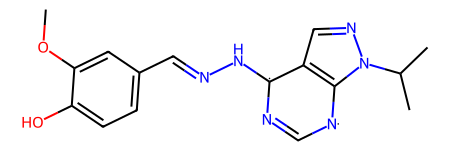

In [80]:
Chem.MolFromSmiles(df_kit_wt_smina['smiles'][0])

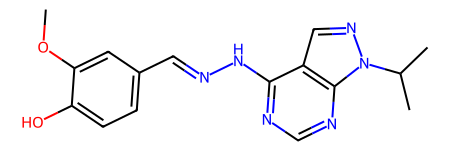

In [94]:
for i in range(207, 208):
    display(Chem.MolFromSmiles(benchmark_table['smiles'][i]))

In [ ]:
single_pose_file = "data/KIT_wt/"

In [57]:
# df_kit_wt_smina['KIT'] = benchmark.dataset.table['KIT']
# df_kit_wt_smina['CLASS_KIT'] = benchmark.dataset.table['CLASS_KIT']
# df_kit_wt_smina_train = df_kit_wt_smina[df_kit_wt_smina['smiles'].isin(train.X)]
# del df_kit_wt_smina # avoid the temptation...

In [58]:
df_kit_train.columns

Index(['smiles', 'minimizedAffinity', 'canonical_smiles', 'KIT', 'CLASS_KIT'], dtype='object')

In [59]:
len(df_kit_train)

0

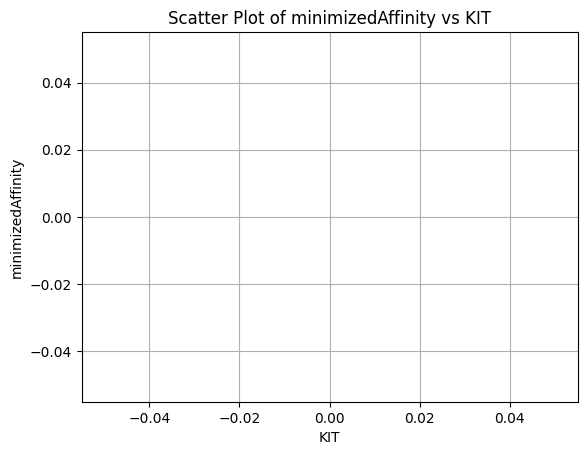

In [48]:
# Assuming 'minimizedAffinity' and 'KIT' are arrays or lists containing your data
import matplotlib.pyplot as plt

plt.scatter(df_kit_train['KIT'], df_kit_train['minimizedAffinity'])
plt.title('Scatter Plot of minimizedAffinity vs KIT')
plt.xlabel('KIT')
plt.ylabel('minimizedAffinity')
plt.grid(True)
plt.show()

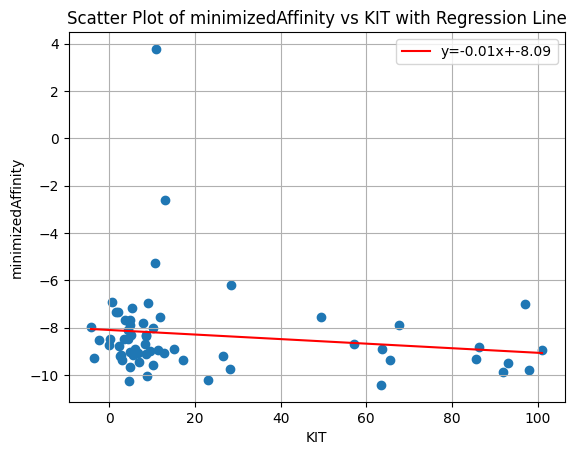

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming 'KIT' and 'minimizedAffinity' are your x and y data arrays respectively
# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(df_kit_wt_smina_train['KIT'], df_kit_wt_smina_train['minimizedAffinity'])

# Generate x values for your regression line (from min to max of your original x data)
line_x = np.linspace(min(df_kit_wt_smina_train['KIT']), max(df_kit_wt_smina_train['KIT']), 100)

# Calculate corresponding y values based on the slope and intercept
line_y = slope * line_x + intercept

# Plot original scatter data
plt.scatter(df_kit_wt_smina_train['KIT'], df_kit_wt_smina_train['minimizedAffinity'])

# Plot linear regression line
plt.plot(line_x, line_y, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')

plt.title('Scatter Plot of minimizedAffinity vs KIT with Regression Line')
plt.xlabel('KIT')
plt.ylabel('minimizedAffinity')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
from sklearn.metrics import precision_recall_curve, auc

# Assuming 'minimizedAffinity' is your score predictions and 'CLASS_KIT' is your ground truth labels
# Ensure your 'CLASS_KIT' data is binary (0s and 1s)

precision, recall, _ = precision_recall_curve(df_kit_wt_smina_train['CLASS_KIT'], -df_kit_wt_smina_train['minimizedAffinity'])
pr_auc = auc(recall, precision)

print(f"PR AUC: {pr_auc}")

precision, recall, _ = precision_recall_curve(df_kit_wt_smina_train['CLASS_KIT'], np.random.rand(len(df_kit_wt_smina_train['CLASS_KIT'])))
pr_auc = auc(recall, precision)

print(f"Random PR AUC: {pr_auc}")

PR AUC: 0.19165154226214134
Random PR AUC: 0.14514161860726166
